<font color="#CA3532" style="font-size:40px"><h1 align="left" >Pruebas con Autoencoders</h1></font>
<font color="#6E6E6E"><h3 align="left">Jaen-Lorites, Jose Manuel</h3></font> 

# Índice:

1. [Preparamos los datos](#init-data)  
2. [Probando las primeras redes (libro)](#first-nets-book)  
    2.1. [Variant Autoencoder](#first-VAe)    
    2.2. [Convolutional Variant Autoencoder](#conv-VAe)



In [1]:
import sys; sys.path.insert(0, '../Scripts')
# import load_images
from load_images import load_images, get_df_paths, gen_data_2, gen_data
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

Succesfull loaded: path_list, labels, split, image_type, file_npy
Succesfull loaded: df_metadata_images


## 1. Preparamos los datos <a class="anchor" id="init-data"></a> 

*TODO:*
- Cambiar/crear nueva función load_images para adaptar al imput del VAe (y seguramente de las demás redes también)

*A probar:*
- Tener tb en cuenta etiqueta para vector latente¿? (tal vez como 2o input, y que vaya directo a capa)

In [2]:
#A partir de la lista, devuelve otra con un plano en lugar de todo el volumen
n_train = 340
n_valid = 50
X_train = load_images(get_df_paths(n=n_train))
X_valid = load_images(get_df_paths(n=n_valid))
'''
¡OJO! puede que muestras estén en ambos subsets. 
Reemplazar por un único load_images, y de ahí coger índices como subsets
'''

'\n¡OJO! puede que muestras estén en ambos subsets. \nReemplazar por un único load_images, y de ahí coger índices como subsets\n'

In [3]:

''' 
------------------------------NO USAR-----------------------------------
02/02/2021: Esta celda era para cuando sólo queriamos un único corte del volumen. 
Se plantea utilizar todos los cortes de cada volumen, con posibilidad de excluir los más externos.
'''
# selecciona_corte = lambda images_unflat,idx_corte: [np.squeeze(x[:,:,idx_corte]) for x in images_unflat]
# idx_corte = 4

# X_train_unicorte = selecciona_corte(X_train, idx_corte)
# X_valid_unicorte = selecciona_corte(X_valid, idx_corte)

# X = np.empty(shape = [n_train,180,180])
# for i,x in enumerate(X_train_unicorte):
#     X[i,:,:] = x
    
# Y = np.empty(shape = [n_valid,180,180])
# for i,x in enumerate(X_valid_unicorte):
#     Y[i,:,:] = x
    

In [21]:
# X = 
# np.load(get_df_paths()["file_path"].iloc[0], allow_pickle=True)[0].shape
# X = X_train
# Y = X_valid

data_gen_args = dict(
                     rotation_range=10, zoom_range=0.05,
                     shear_range=10)
                     # width_shift_range=0.1,
                     # height_shift_range=0.1,
                     # zoom_range=0.2)
            
# ds, ds_val = gen_data_2(1.0, 40, data_gen_args, n_load=10) #n_load=0 -> todas las imagenes posibles
ds, ds_val = gen_data(10, 4, data_gen_args, n_load=100) #n_load=0 -> todas las imagenes posibles

ims cargadas
ds_train y ds_val generados
ds_gen generado v3
ds concatenado


In [22]:
ds.as_numpy_iterator().next()[0]

array([[[1.21741005e-311],
        [1.21682437e-311],
        [9.02138054e-002],
        ...,
        [2.12332215e-002],
        [4.34105136e-002],
        [6.57479689e-002]],

       [[8.47390220e-002],
        [9.23590362e-002],
        [7.68745467e-002],
        ...,
        [3.78437117e-002],
        [4.25675958e-002],
        [4.98314835e-002]],

       [[6.41688928e-002],
        [7.71885365e-002],
        [7.58672506e-002],
        ...,
        [0.00000000e+000],
        [0.00000000e+000],
        [0.00000000e+000]],

       ...,

       [[0.00000000e+000],
        [0.00000000e+000],
        [0.00000000e+000],
        ...,
        [0.00000000e+000],
        [0.00000000e+000],
        [0.00000000e+000]],

       [[0.00000000e+000],
        [0.00000000e+000],
        [0.00000000e+000],
        ...,
        [0.00000000e+000],
        [0.00000000e+000],
        [0.00000000e+000]],

       [[0.00000000e+000],
        [0.00000000e+000],
        [0.00000000e+000],
        ...,
        

## 2. Probando las primeras redes (libro) <a class="anchor" id="first-nets-book"></a>   

En este apartado pretendo probar, de forma muy básica, las distintas redes generativas que se comentan en el libro *Hands on Machine Learning, Ed. 2*

### 2.1. Variant Autoencoder <a class="anchor" id="first-VAe"></a>

*TODO:*  
- Adapt shape inputs
- Find and put all the hyperparameters at the top of the chunk
- Test the net with a little subset

* Adapt to convolutional and deconvolutional layers

In [7]:
######## Train the model ########
#### Hyperparameters
codings_size = 10 # Vector size which represents the latent space ¿?

#### Custom layer to sample the codings, given μ and γ 
# μ = mean
# γ = log_var = log(sigma^2), where sigma is standard deviation
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

class VAE(tf.keras.Model):
    def __init__(self, codings_size):
        super().__init__() #Ejecutamos init de tf.keras.Model
        self.codings_size = codings_size
        
        ### Encoder
        inputs = keras.Input(shape=[180, 180, 1]) 
        z = tf.keras.layers.Flatten()(inputs)
        z = keras.layers.Dense(150, activation="selu")(z)
        z = keras.layers.Dense(100, activation="selu")(z)
        z = keras.layers.Dense(50, activation="selu")(z)
        # No activation
#         tf.keras.layers.Dense(latent_dim + latent_dim)(z)
        codings_mean = keras.layers.Dense(codings_size)(z) # μ
        codings_log_var = keras.layers.Dense(codings_size)(z) # γ
        codings = Sampling()([codings_mean, codings_log_var])
        self.encoder = keras.Model(
            inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
        
        ### Decoder
        decoder_inputs = keras.layers.Input(shape=[codings_size])
        x = keras.layers.Dense(50, activation="selu")(decoder_inputs)
        x = keras.layers.Dense(100, activation="selu")(x)
        x = keras.layers.Dense(150, activation="selu")(x)
        x = keras.layers.Dense(180 * 180, activation="sigmoid")(x)
        outputs = keras.layers.Reshape([180, 180, 1])(x)
        self.decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
        
        ### Final Model
        _, _, codings = self.encoder(inputs) # two first arguments not needed
        reconstructions = self.decoder(codings)
        self.VAE_model = keras.Model(inputs=[inputs], outputs=[reconstructions])
        #### Latent loss and reconstruction loss
        latent_loss = -0.5 * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1)
        self.VAE_model.add_loss(K.mean(latent_loss) / 32400.) # 180*180 = 32400 -> Dividimos entre el número de píxeles.
        self.VAE_model.compile(loss="binary_crossentropy", optimizer="rmsprop")
        
    def fit_model(self, X_train, X_val, epochs = 200, batch_size = 128):
        self.VAE_model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                            validation_data=[X_val, X_val])
        self.model_fitted = True
    
    def fit_model_2(self, X_train, X_val, epochs = 200, batch_size = 256):
        '''To use with Dataset object as input'''
        self.history = self.VAE_model.fit(X_train.batch(batch_size), epochs=epochs, validation_data=X_val.batch(batch_size))
        self.model_fitted = True
    
    def generate_image(self, n_images = 6):
        if not self.model_fitted:
            print("Modelo no entrenado")
            
        codings = tf.random.normal(shape=[n_images, self.codings_size])
        return self.decoder(codings).numpy()
    
    def generate_and_show_images(self):
        images = self.generate_image(n_images = 6)
        plt.figure(figsize = (20,15))
#         plt.suptitle("VAe Dense(150,100,50)\ncoding_size = 10; epoch = 500; batch_size = 256\nn_train = 340; n_valid = 50\nSystole - slice 4")

        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.imshow(images[i,:,:])

Epoch 1/2
10/10 [==============================] - 1s 134ms/step - loss: nan - val_loss: nan
Epoch 2/2
10/10 [==============================] - 0s 46ms/step - loss: nan - val_loss: nan


C:\Users\UPVUSER\anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\UPVUSER\anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\UPVUSER\anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
C:\Users\UPVUSER\anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)


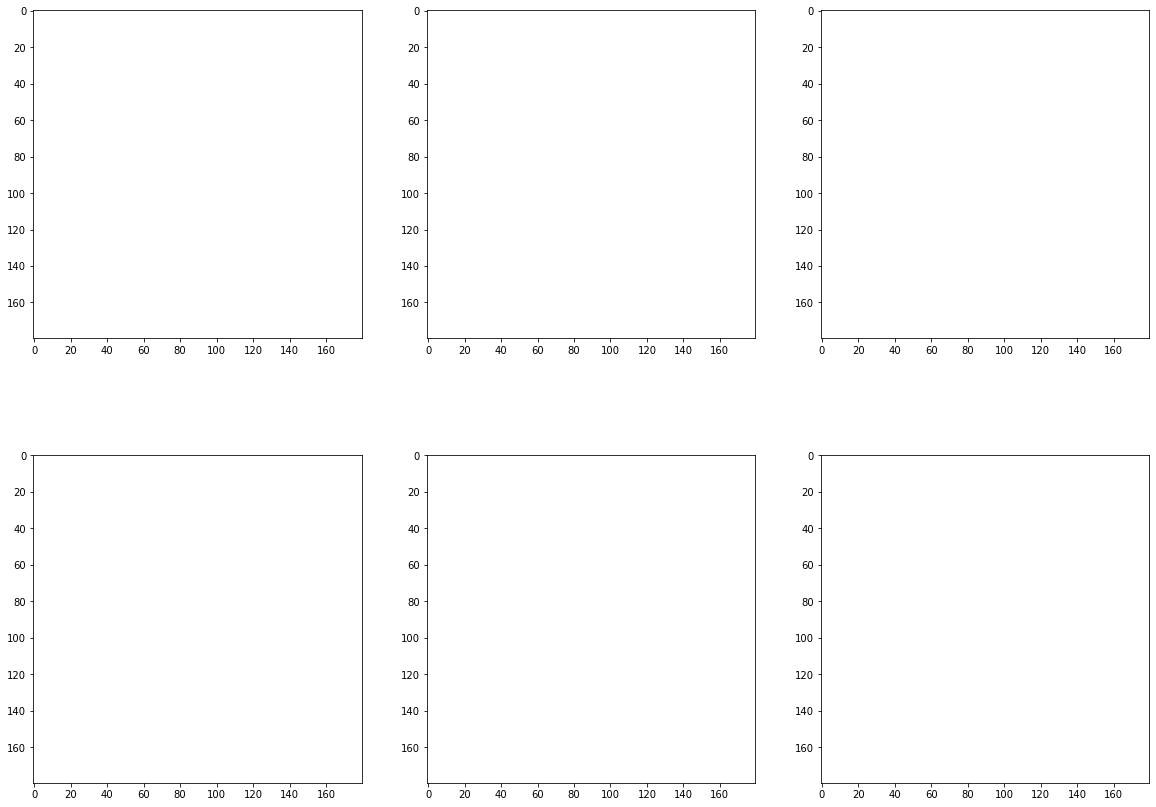

In [9]:
variational = VAE(10)
variational.fit_model_2(ds, ds_val, epochs = 2, batch_size = 100)
variational.generate_and_show_images()

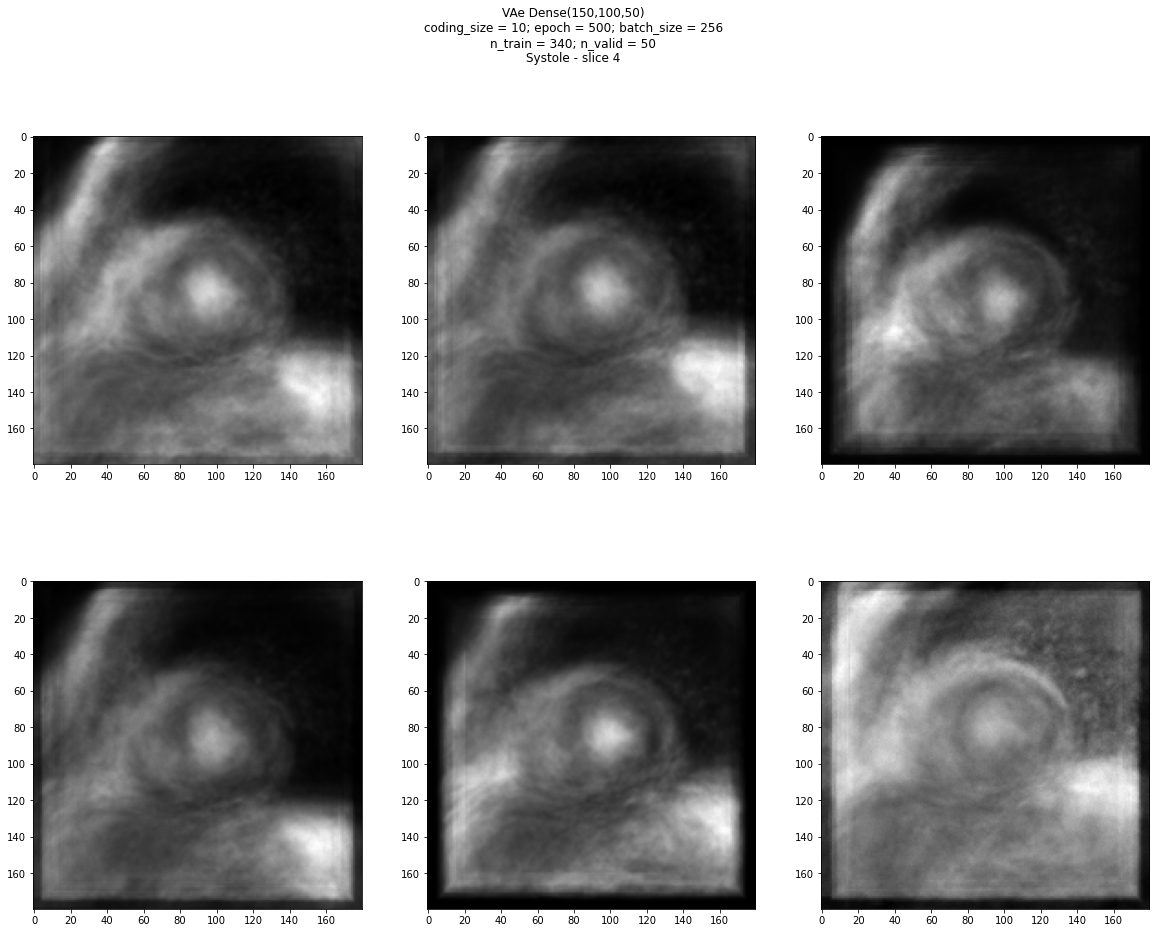

In [36]:
plt.figure(figsize = (20,15))
plt.suptitle("VAe Dense(150,100,50)\ncoding_size = 10; epoch = 500; batch_size = 256\nn_train = 340; n_valid = 50\nSystole - slice 4")

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i,:,:])

# plt.savefig("../generated_images/VAe/2021_01_29.jpeg")

### 2.2. Convolutional Variant Autoencoder <a class="anchor" id="conv-VAe"></a>

<a href='https://www.tensorflow.org/tutorials/generative/cvae?hl=es-419'>Enlace a ejemplo de TensorFlow</a>

In [7]:
X[:,:,:,np.newaxis].shape

(340, 180, 180, 1)

In [3]:
#### Custom layer to sample the codings, given μ and γ 
# μ = mean
# γ = log_var = log(sigma^2), where sigma is standard deviation
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

class CVAE(tf.keras.Model):
    def __init__(self, codings_size):
        super().__init__() #Ejecutamos init de tf.keras.Model
        self.codings_size = codings_size
        print("Inicializando...")
        ### Encoder
        inputs = keras.Input(shape=[180, 180, 1]) # Revisar si es necesario esto
        z = tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu')(inputs)
        z = tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu')(z)
        z = tf.keras.layers.Flatten()(z)
        # No activation
#         tf.keras.layers.Dense(latent_dim + latent_dim)(z)
        codings_mean = keras.layers.Dense(codings_size)(z) # μ
        codings_log_var = keras.layers.Dense(codings_size)(z) # γ
        codings = Sampling()([codings_mean, codings_log_var])
        self.encoder = keras.Model(
            inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
        print("Encoder creado")
        ### Decoder
        decoder_inputs = keras.layers.Input(shape=[codings_size])
        final_shape = int(180/4) # shape[0] at the encoding before flatten
        print("Decoder Inputs creados")
        x = tf.keras.layers.Dense(units=32*(final_shape)**2, activation=tf.nn.relu)(decoder_inputs)
        print("Decoder primera densa creada")
        x = tf.keras.layers.Reshape(target_shape=(final_shape, final_shape, 32))(x)
        print("Decoder reshape hecho")
        x = tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu')(x)
            # No activation
        print("Decoder Layers creados")
        outputs = tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same')(x)
        self.decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
        print("Decoder creado")
        ### Final Model
        _, _, codings = self.encoder(inputs) # two first arguments not needed
        reconstructions = self.decoder(codings)
        self.CVAE_model = keras.Model(inputs=[inputs], outputs=[reconstructions])
        #### Latent loss and reconstruction loss
        latent_loss = -0.5 * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1)
        self.CVAE_model.add_loss(K.mean(latent_loss) / 32400.) # 180*180 = 32400 -> Dividimos entre el número de píxeles.
        self.CVAE_model.compile(loss="binary_crossentropy", optimizer="adam")

    def fit_model(self, X_train, X_val, epochs = 200, batch_size = 128):
        self.epochs = epochs
        self.batch_size = batch_size
        self.CVAE_model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                            validation_data=[X_val, X_val])
        self.model_fitted = True
        
    def fit_model_2(self, X_train, X_val, epochs = 200, batch_size = 256):
        '''To use with Dataset object as input'''
        self.epochs = epochs
        self.batch_size = batch_size
        self.CVAE_model.fit(X_train.batch(batch_size), epochs=epochs, validation_data=X_val)
        self.model_fitted = True
    
    def generate_image(self, n_images = 6):
        if not self.model_fitted:
            print("Modelo no entrenado")
            
        codings = tf.random.normal(shape=[n_images, self.codings_size])
        return self.decoder(codings).numpy()
    
    def generate_and_show_images(self):
        images = self.generate_image(n_images = 6)
        plt.figure(figsize = (20,15))
        plt.suptitle(f"Conv_VAe \ncoding_size = 10; epochs = {self.epochs}; batch_size = {self.batch_size}\nn_train = 340; n_valid = 50\nSystole - slice 4")

        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.imshow(images[i,:,:])

In [4]:
cvae_model = CVAE(15)
# cvae_model.fit_model(X[:,:,:,np.newaxis], Y[:,:,:,np.newaxis])
cvae_model.fit_model_2(ds, ds_val)
cvae_model.generate_and_show_images()

Inicializando...
Encoder creado
Decoder Inputs creados
Decoder primera densa creada
Decoder reshape hecho
Decoder Layers creados
Decoder creado


ValueError: in converted code:

    C:\Users\UPVUSER\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py:677 map_fn
        batch_size=None)
    C:\Users\UPVUSER\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py:2410 _standardize_tensors
        exception_prefix='input')
    C:\Users\UPVUSER\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (None, 1, 180, 180, 1)


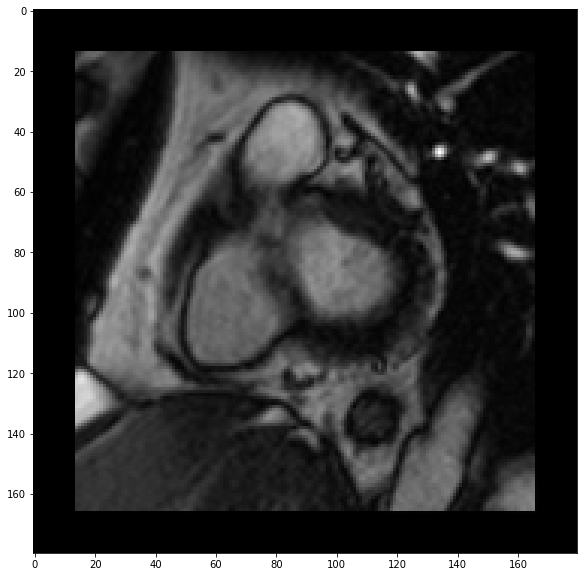

In [39]:
%matplotlib inline
import time
from IPython.display import clear_output
images = load_images(get_df_paths(n = 3)) 

plt.figure(figsize=(10,10))
for i in range (10-1):
    for j in range(1):
#         plt.subplot(1,2,j+1)
        plt.figure(figsize=(10,10))
        plt.imshow(images[j][:,:,i])
        plt.show()
    time.sleep(0.8)
    clear_output(wait=True)

<ConcatenateDataset shapes: (<unknown>, <unknown>), types: (tf.float64, tf.float64)>